# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [2]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import cv2
cap = cv2.VideoCapture(1)

## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
#sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

C:\Users\Suchit Adak\bazel\models-master\models-master\research\object_detection\utils\visualization_utils.py:26: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
#CKPT = tf.train.latest_checkpoint('train_out')
#CKPT = 'ssd_inception_v2_coco_11_06_2017/frozen_inference_graph.pb'
#CKPT = 'frozen_out/resnet-20707-50-proposals/frozen_inference_graph.pb'

#CKPT = 'frozen_out/resnet-udacity-real-large-20k/frozen_inference_graph.pb'

CKPT = 'frozen_inference_graph.pb'

#CKPT = 'frozen_out/resnet-udacity-93-samples-3000/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data_samples/label_map.pbtxt'

NUM_CLASSES = 14

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(CKPT, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'GreenLeft'}, 4: {'id': 4, 'name': 'GreenRight'}, 5: {'id': 5, 'name': 'RedLeft'}, 6: {'id': 6, 'name': 'RedRight'}, 7: {'id': 7, 'name': 'Yellow'}, 8: {'id': 8, 'name': 'off'}, 9: {'id': 9, 'name': 'RedStraight'}, 10: {'id': 10, 'name': 'GreenStraight'}, 11: {'id': 11, 'name': 'GreenStraightLeft'}, 12: {'id': 12, 'name': 'GreenStraightRight'}, 13: {'id': 13, 'name': 'RedStraightLeft'}, 14: {'id': 14, 'name': 'RedStraightRight'}}


## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
from glob import glob

In [10]:
 
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = 'test_images_sim'
#PATH_TO_TEST_IMAGES_DIR = 'test_images'
#PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'
#PATH_TO_TEST_IMAGES_DIR = 'data/integration-project-data/bag_dump_just_traffic_light/green'

#PATH_TO_TEST_IMAGES_DIR = 'data/sim_training_data/red'
PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
#TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.png'))  # PNG OR JPG
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test_images_udacity\*.jpg
Length of test images: 9


In [11]:
import time

# 10 regions

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            print("Time in milliseconds", (time1 - time0) * 1000) 

            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
            
            cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

Time in milliseconds 4128.454685211182
Time in milliseconds 134.53125953674316
Time in milliseconds 118.25323104858398
Time in milliseconds 120.47195434570312
Time in milliseconds 155.58767318725586
Time in milliseconds 113.4653091430664
Time in milliseconds 130.8751106262207
Time in milliseconds 128.434419631958
Time in milliseconds 125.96845626831055


Time in milliseconds 4434.541940689087


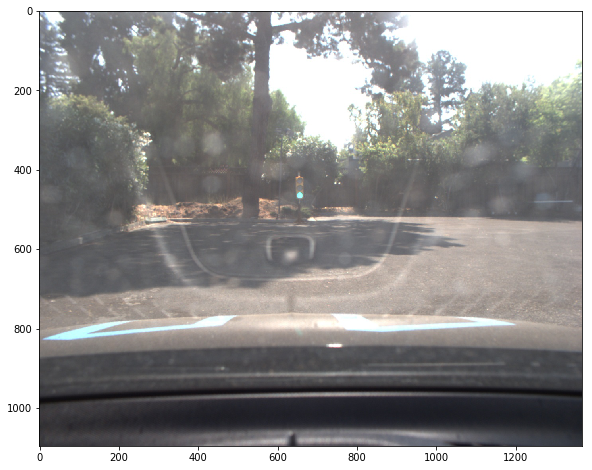

Time in milliseconds 128.64208221435547


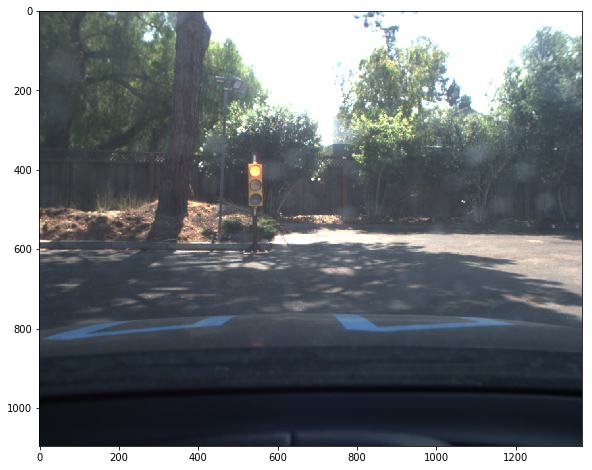

Time in milliseconds 163.93065452575684


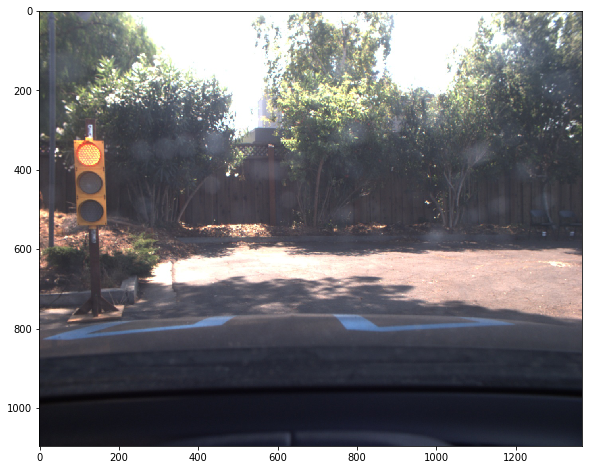

Time in milliseconds 150.5439281463623


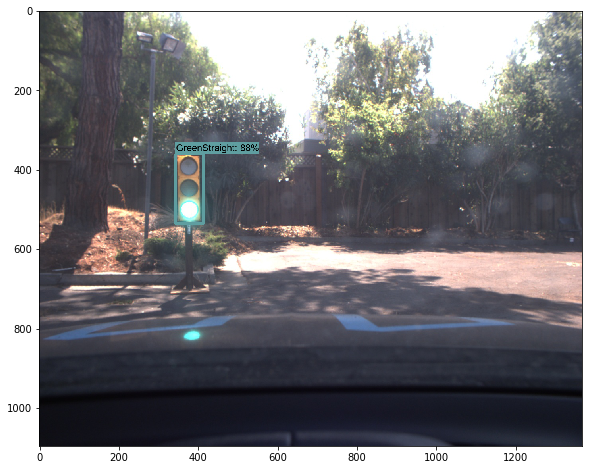

Time in milliseconds 106.23764991760254


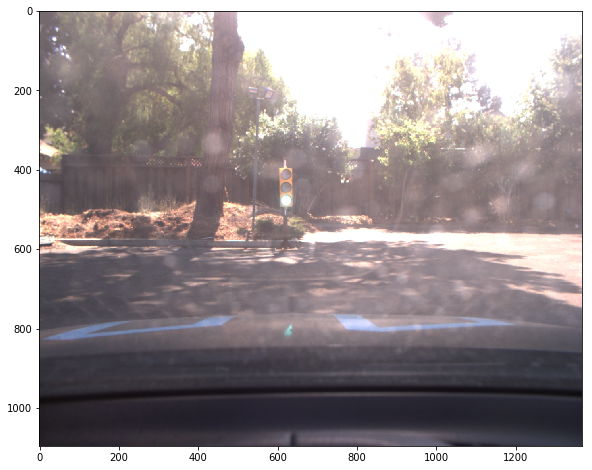

Time in milliseconds 108.58607292175293


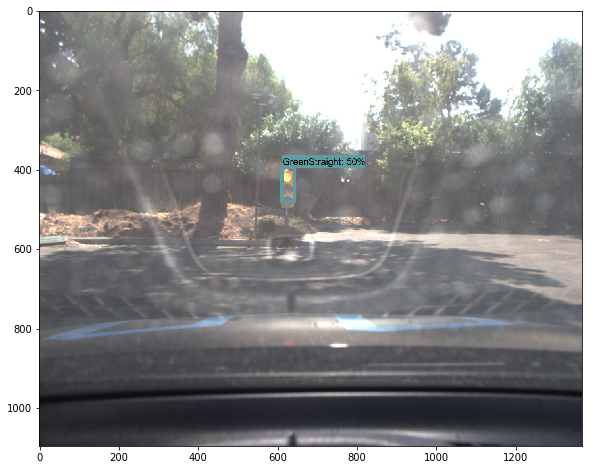

Time in milliseconds 110.50081253051758


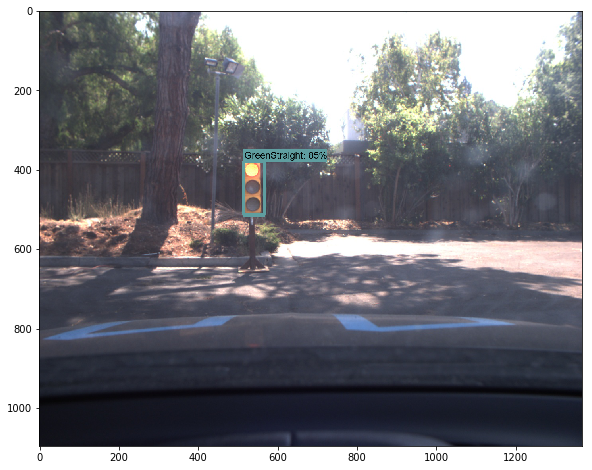

Time in milliseconds 108.66403579711914


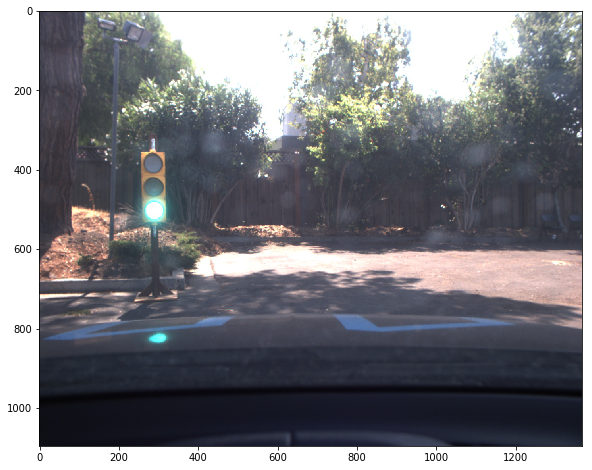

Time in milliseconds 120.92947959899902


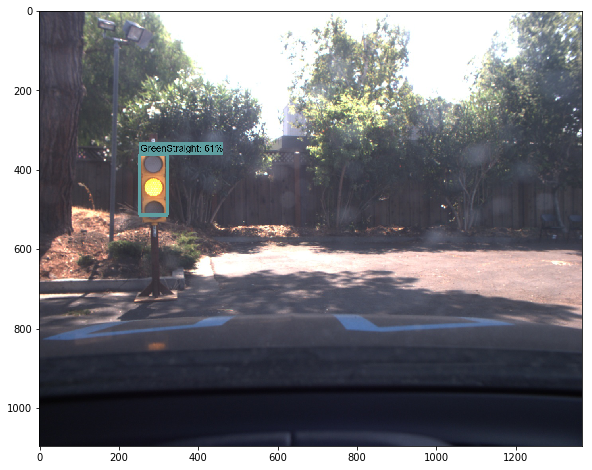

In [50]:
import time

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            print("Time in milliseconds", (time1 - time0) * 1000) 

            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            